In [1]:
import os
import glob
import scipy.io
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D
from tensorflow.keras.models import Model

import load_mat_images # our own module to read data

2025-05-02 14:17:48.787165: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-05-02 14:17:48.788825: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-05-02 14:17:48.791713: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-05-02 14:17:48.800963: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1746209868.816698  722251 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1746209868.82

In [2]:
train_ds, val_ds, scale=load_mat_images.load_dataset(fullset=True, height=101, width=101)  # False: only take 100 images for quick tests

gmi shape:  (3111, 101, 101)  ssmis shape:  (3111, 101, 101)
max scaled gmi value:  1.0  max scaled ssmis value:  0.51787764
train_target.shape:  (2488, 101, 101, 1) train_data.shape:  (2488, 101, 101, 1)
test_target.shape:  (623, 101, 101, 1) test_data.shape:  (623, 101, 101, 1)
max train_target:  1.0 max train_data:  0.43745303
min train_target:  0.0 min train_data:  0.0


2025-05-02 14:21:27.861330: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


In [3]:
 
print("len(train_ds): ", len(train_ds), " len(val_ds): ", len(val_ds)) 

len(train_ds):  156  len(val_ds):  39


train_samples shape:  (16, 101, 101, 1)  target_samples shape:  (16, 101, 101, 1)
train_samples max:  0.38039955 target_samples max:  0.6133936


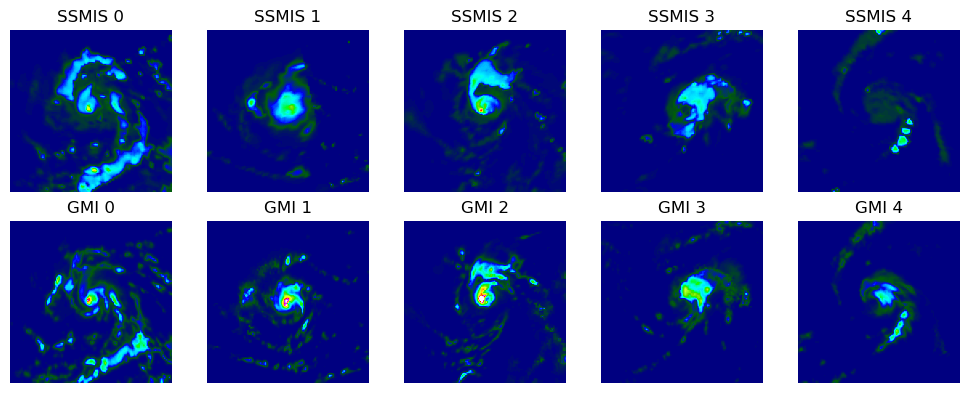

In [4]:
 
# Get a batch from the dataset
for train_batch, target_batch in train_ds.take(1):  # Take one batch
    train_samples = train_batch.numpy()  # Convert to NumPy for visualization
    target_samples = target_batch.numpy()
    print("train_samples shape: ",     train_samples.shape, 
          " target_samples shape: ",   target_samples.shape)
    print("train_samples max: ", np.amax(train_samples), 
          "target_samples max: ", np.amax(target_samples))
    break  # Exit after one batch

# Number of samples to display
num_samples = min(5, train_samples.shape[0])  # Ensure we don't exceed batch size

# Plot the images
fig, axes = plt.subplots(2, num_samples, figsize=(num_samples * 2, 4))

for i in range(num_samples):
    # Plot train_data image
    axes[0, i].imshow(train_samples[i].squeeze(), cmap='gist_ncar', vmin=0, vmax=.35)
    axes[0, i].set_title(f"SSMIS {i}")
    axes[0, i].axis("off")

    # Plot train_target image
    axes[1, i].imshow(target_samples[i].squeeze(), cmap='gist_ncar', vmin=0, vmax=.35)
    axes[1, i].set_title(f"GMI {i}")
    axes[1, i].axis("off")

plt.tight_layout()
plt.show()


In [17]:
epochs=40

def ssim_loss(y_true, y_pred):
    return 1 - tf.reduce_mean(tf.image.ssim(y_true, y_pred, max_val=1.0))
    
# Encoder
input_img = Input(shape=(101, 101, 1))

x = Conv2D(64, (9, 9), activation="relu", padding="same")(input_img)
x = Conv2D(32, (1, 1), activation="relu", padding="same")(x)
output_img = Conv2D(1, (5, 5), activation="relu", padding="same")(x)

# Compile & Train
autoencoder = Model(input_img, output_img)
#autoencoder.compile(optimizer="adam", loss="mae") # not working for epochs=4
#autoencoder.compile(optimizer="adam", loss="mse") # not working for epochs=4
autoencoder.compile(optimizer="adam", loss=ssim_loss, metrics=['mse']) # works for epochs=4, 10, 100

autoencoder.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 101, 101, 1)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 101, 101, 64)   │         5,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 101, 101, 32)   │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 101, 101, 1)    │           801 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,129 (31.75 KB)

 Trainable params: 8,129 (31.75 KB)

 Non-trainable params: 0 (0.00 B)

In [18]:
history=autoencoder.fit(train_ds, validation_data=val_ds, epochs=epochs)

Epoch 1/40
156/156 ━━━━━━━━━━━━━━━━━━━━ 5s 24ms/step - loss: 0.1018 - mse: 2.8405e-04 - val_loss: 0.0865 - val_mse: 2.3156e-04
Epoch 2/40
156/156 ━━━━━━━━━━━━━━━━━━━━ 4s 23ms/step - loss: 0.0900 - mse: 2.4463e-04 - val_loss: 0.0863 - val_mse: 2.3126e-04
Epoch 3/40
156/156 ━━━━━━━━━━━━━━━━━━━━ 4s 23ms/step - loss: 0.0895 - mse: 2.4165e-04 - val_loss: 0.0861 - val_mse: 2.3075e-04
Epoch 4/40
156/156 ━━━━━━━━━━━━━━━━━━━━ 4s 23ms/step - loss: 0.0892 - mse: 2.4070e-04 - val_loss: 0.0861 - val_mse: 2.3076e-04
Epoch 5/40
156/156 ━━━━━━━━━━━━━━━━━━━━ 4s 23ms/step - loss: 0.0890 - mse: 2.3998e-04 - val_loss: 0.0862 - val_mse: 2.3008e-04
Epoch 6/40
156/156 ━━━━━━━━━━━━━━━━━━━━ 4s 23ms/step - loss: 0.0886 - mse: 2.3914e-04 - val_loss: 0.0857 - val_mse: 2.2922e-04
Epoch 7/40
156/156 ━━━━━━━━━━━━━━━━━━━━ 4s 23ms/step - loss: 0.0882 - mse: 2.3863e-04 - val_loss: 0.0858 - val_mse: 2.2813e-04
Epoch 8/40
156/156 ━━━━━━━━━━━━━━━━━━━━ 4s 23ms/step - loss: 0.0881 - mse: 2.3791e-04 - val_loss: 0.0856 - val_

In [35]:
#autoencoder.save('autoencoder_'+ str(epochs) + '_epochs.keras')
#tf.keras.utils.plot_model(autoencoder, show_shapes=True, show_dtype=True, show_layer_names=True)
#history.history

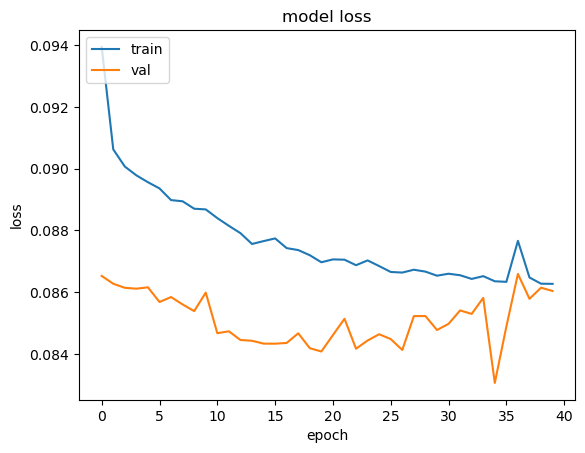

In [36]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

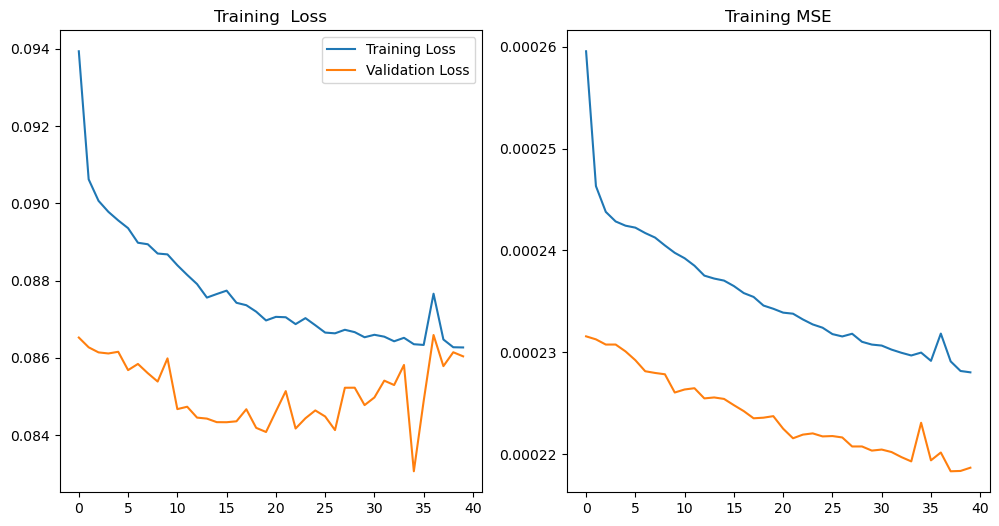

In [37]:
mse = history.history['mse']
val_mse = history.history['val_mse']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 2)
plt.plot(epochs_range, mse, label='Training MSE')
plt.plot(epochs_range, val_mse, label='Validation MSE')
#plt.legend(loc='lower right')
plt.title('Training MSE')

plt.subplot(1, 2, 1)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training  Loss')
plt.show()


In [38]:

# Validation

predictions=np.empty([0, 101, 101, 1]) 
low_res=np.empty([0, 101, 101, 1]) 
high_res=np.empty([0, 101, 101, 1]) 

for low_res1, high_res1 in val_ds:   # test all val_ds samples
    prediction = autoencoder.predict(low_res1)
    predictions=np.concatenate((predictions, prediction))
    low_res=np.concatenate((low_res, low_res1))
    high_res=np.concatenate((high_res, high_res1))
    
predictions.shape

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━

2025-05-02 16:02:32.136797: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


(623, 101, 101, 1)

In [39]:
len(low_res)
#np.random.randint(1, high=len(low_res)-1)

623

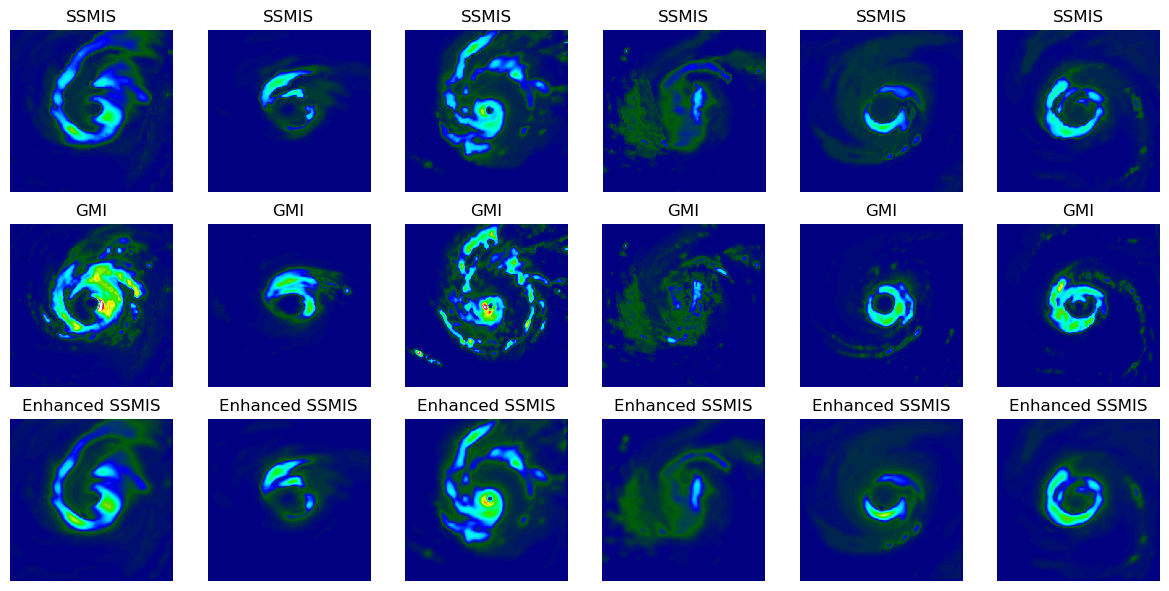

In [40]:
# Plot a few samples
#np.random.seed(seed=1234)
num_samples = 6
fig, axes = plt.subplots(3, num_samples, figsize=(num_samples * 2, 6))

for i in range(num_samples):
    j=np.random.randint(1, high=len(low_res)-1) # select random sample
    # Low-quality input
    axes[0, i].imshow(low_res[j].squeeze(), cmap="gist_ncar", vmin=0, vmax=.35)
    axes[0, i].set_title("SSMIS")
    axes[0, i].axis("off")

    # Ground truth high-quality
    axes[1, i].imshow(high_res[j].squeeze(), cmap="gist_ncar", vmin=0, vmax=.35)
    axes[1, i].set_title("GMI")
    axes[1, i].axis("off")

    # Model prediction
    axes[2, i].imshow(predictions[j].squeeze(), cmap="gist_ncar", vmin=0, vmax=.35)
    axes[2, i].set_title("Enhanced SSMIS")
    axes[2, i].axis("off")

plt.tight_layout()
plt.show()

In [41]:
predictions.shape

(623, 101, 101, 1)

In [42]:
print("max of predictions:", np.amax(predictions)*scale, " max of target: ", np.amax(high_res)*scale)

max of predictions: 70.18739212054834  max of target:  118.3974997978703


In [43]:
print("max of low_res: ", np.amax(low_res)*scale) 

max of low_res:  75.39457147546727


In [44]:
print ("min of predictions:", np.amin(predictions)*scale,  "min of target: ", np.amin(high_res)*scale)

min of predictions: 0.0 min of target:  0.0


In [45]:
from scipy.stats import gaussian_kde
from sklearn.metrics import root_mean_squared_error

# Assuming prediction and high_res have shape (16, 96, 96, 1) in each batch 
# Flatten them to 1D arrays
pred_flat = predictions.flatten()*scale  # prediction, i.e., enhanced SSMIS
gt_flat = high_res.flatten()*scale   # groud truth, i.e., GMI
lr_flat = low_res.flatten()*scale 

bias_hr = np.mean(pred_flat) - np.mean(gt_flat) 
bias_lr = np.mean(lr_flat) - np.mean(gt_flat) 

print(f"Bias before: {bias_lr:.3f}, Bias after: {bias_hr:.3f}") 

rms_hr = root_mean_squared_error(gt_flat, pred_flat)
rms_lr = root_mean_squared_error(gt_flat, lr_flat)

print(f"RMSE before: {rms_lr:.3f}, RMSE after: {rms_hr:.3f}")

cor_hr=np.corrcoef(gt_flat, pred_flat)[0, 1]
cor_lr=np.corrcoef(gt_flat, lr_flat)[0, 1]
print(f"Corr before: {cor_lr:.3f}, Corr after: {cor_hr:.3f}")

Bias before: -0.143, Bias after: -0.044
RMSE before: 2.271, RMSE after: 2.153
Corr before: 0.765, Corr after: 0.787


/data1/tiany/anaconda3/lib/python3.12/site-packages/mpl_scatter_density/generic_density_artist.py:77: RuntimeWarning: All-NaN slice encountered
  vmin = self._density_vmin(array)
/data1/tiany/anaconda3/lib/python3.12/site-packages/mpl_scatter_density/generic_density_artist.py:82: RuntimeWarning: All-NaN slice encountered
  vmax = self._density_vmax(array)


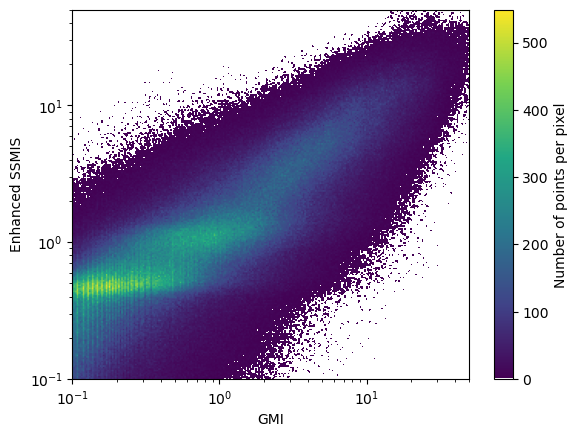

In [30]:
import mpl_scatter_density # adds projection='scatter_density'
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.pyplot as plt
import numpy as np

# Fake data for testing
x = gt_flat
y = pred_flat# Assume x and y are NumPy arrays of the same shape

mask = (x > 0.1) & (y > 0.1)

# Apply the mask
x1 = x[mask]
y1 = y[mask]


# "Viridis-like" colormap with white background
white_viridis = LinearSegmentedColormap.from_list('white_viridis', [
    (0, '#ffffff'),
    (1e-20, '#440053'),
    (0.2, '#404388'),
    (0.4, '#2a788e'),
    (0.6, '#21a784'),
    (0.8, '#78d151'),
    (1, '#fde624'),
], N=256)

def using_mpl_scatter_density(fig, x1, y1):
    ax = fig.add_subplot(1, 1, 1, projection='scatter_density')
    density = ax.scatter_density(x1, y1, cmap=white_viridis)
    fig.colorbar(density, label='Number of points per pixel')
    ax.set_xlim(0.1, 50)
    ax.set_ylim(0.1, 50)
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_xlabel('GMI')
    ax.set_ylabel('Enhanced SSMIS')
 

fig = plt.figure()
using_mpl_scatter_density(fig, x1, y1)
plt.show()

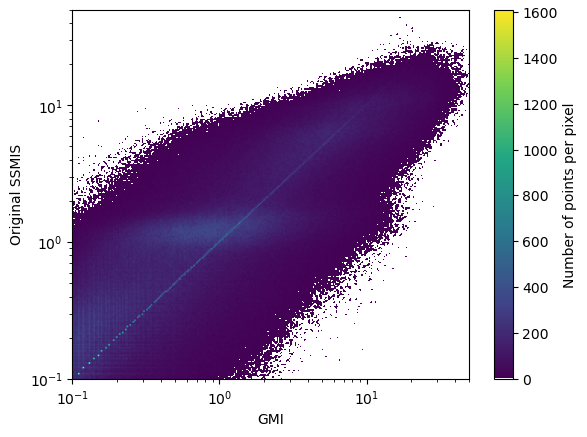

In [31]:
 
# Fake data for testing
x = gt_flat
y = lr_flat# Assume x and y are NumPy arrays of the same shape

mask = (x > 0.1) & (y > 0.1)

# Apply the mask
x1 = x[mask]
y1 = y[mask]


# "Viridis-like" colormap with white background
white_viridis = LinearSegmentedColormap.from_list('white_viridis', [
    (0, '#ffffff'),
    (1e-20, '#440053'),
    (0.2, '#404388'),
    (0.4, '#2a788e'),
    (0.6, '#21a784'),
    (0.8, '#78d151'),
    (1, '#fde624'),
], N=256)

def using_mpl_scatter_density(fig, x1, y1):
    ax = fig.add_subplot(1, 1, 1, projection='scatter_density')
    density = ax.scatter_density(x1, y1, cmap=white_viridis)
    fig.colorbar(density, label='Number of points per pixel') #, boundaries=np.array([0, 100, 200, 300, 400, 500]))
    ax.set_xlim(0.1, 50)
    ax.set_ylim(0.1, 50)
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_xlabel('GMI')
    ax.set_ylabel('Original SSMIS')
 

fig = plt.figure()
using_mpl_scatter_density(fig, x1, y1)
plt.show()